# Applying Raw Data Filtering and Subsample for RNN

## Import Data - Colab Using Only (skip when running on local)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
! unzip ./gdrive/My\ Drive/data.zip

Archive:  ./gdrive/My Drive/data.zip
replace data/X_train_valid.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
! mv data/*.npy .

## Import Library and Data

In [0]:
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.layers import Lambda

In [0]:
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

person_train_valid = np.load("person_train_valid.npy")
person_test = np.load("person_test.npy")

# Remove EOG (last three channels)
X_train_valid = X_train_valid[:, :22, :]
X_test = X_test[:, :22, :]

## Filtering

In [0]:
'''Filter'''

from scipy.signal import savgol_filter

window_size = 13
polynomial_order = 2

X_train_valid = savgol_filter(X_train_valid, window_size, polynomial_order)
X_test = savgol_filter(X_test, window_size, polynomial_order)
    


## Subsample

In [0]:
# Subsample: 2 times

X_train_valid = np.vstack(( X_train_valid[:,:,[(2*i) for i in range(500)]] , X_train_valid[:,:,[(2*i+1) for i in range(500)]]))
    
X_test = np.vstack(( X_test[:,:,[(2*i) for i in range(500)]] , X_test[:,:,[(2*i+1) for i in range(500)]]))
    
y_train_valid = np.concatenate((y_train_valid, y_train_valid))
y_test = np.concatenate((y_test, y_test))

## Preprocessing Data for Training

In [0]:
X_train_valid = np.expand_dims(X_train_valid, 3)
X_test = np.expand_dims(X_test, 3)

person_train_valid = np.squeeze(person_train_valid)
person_test = np.squeeze(person_test)

y_train_valid -= 769
y_test -= 769


In [25]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))

print ('Test data shape: {}'.format(X_test.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (4230, 22, 500, 1)
Training/Valid target shape: (4230,)
Person train/valid shape: (2115,)
Test data shape: (886, 22, 500, 1)
Test target shape: (886,)
Person test shape: (443,)


## RNN Model

In [0]:
def create_model(n_filters=64, n_neurons=256, drops=[0.25,0.25,0.25], lr=1e-4, subject=False, subsample_scale = 1):
    
    # drops[0]: conv drop
    # drops[1]: GRU drop
    # drops[2]: GRU recurrent drop
    
    
    inputs = layers.Input(X_train_valid[0].shape)
    
    # conv
    x = layers.Conv2D(n_filters, (1,5//subsample_scale), (1,5//subsample_scale), 'valid')(inputs)
    #x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, (22, 1), (1,1), 'valid')(x)
    x = layers.ELU()(x)
    #x = layers.ReLU()(x)
    #x = layers.MaxPool2D((1,4), (1,1))(x)
    x = layers.AveragePooling2D((1,2), (1,2))(x)
    
    x = layers.Dropout(drops[0])(x)
    
    # reshape
    #x = layers.Permute((3,2,1))(x)
    x = layers.Permute((2,3,1))(x)
    
    def remove_axis(x):
        return backend.squeeze(x, 3)
    
    x = Lambda(remove_axis)(x)
      
    # LSTM
    x = layers.Bidirectional(layers.LSTM(n_neurons, dropout=drops[1], recurrent_dropout=drops[2]))(x)
    
    if subject:
        predictions = layers.Dense(9, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)
    else:
        predictions = layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)
    
    
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    
    model.summary()
    
    # compile
    model.compile(optimizer=tf.train.AdamOptimizer(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## Control Group

In [10]:
model_sig = create_model(n_filters=32, n_neurons=256, drops=[0.05, 0.05, 0.05])

history_sig = model_sig.fit(X_train_valid, y_train_valid, validation_data=(X_test, y_test), epochs=200, batch_size=512, verbose=1)

#model.evaluate(X_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 200, 32)       192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 200, 32)        22560     
_________________________________________________________________
elu (ELU)                    (None, 1, 200, 32)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 100, 32)        0         
_________________________________________________________________
dropout (Dropout)    

Max Validation Accuracy: 0.5778781
Max Training Accuracy: 0.92671394


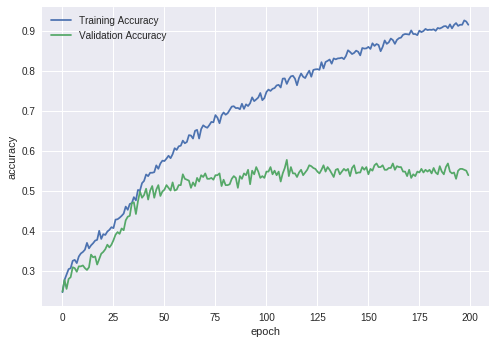

In [12]:
val_acc_control = history_sig.history['val_acc']

print('Max Validation Accuracy:', max(val_acc_control))

acc_control = history_sig.history['acc']
print('Max Training Accuracy:', max(acc_control))

plt.plot(acc_control, label = 'Training Accuracy')
plt.plot(val_acc_control, label = 'Validation Accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()

plt.show()

## Filtering Only

In [18]:
model_filter = create_model(n_filters=32, n_neurons=256, drops=[0.05, 0.05, 0.05])

history_filter = model_filter.fit(X_train_valid, y_train_valid, validation_data=(X_test, y_test), epochs=200, batch_size=512, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 200, 32)       192       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 200, 32)        22560     
_________________________________________________________________
elu_1 (ELU)                  (None, 1, 200, 32)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 100, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 100, 32)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 100, 32, 1)        0         
__________

Max Validation Accuracy: 0.59142214
Max Training Accuracy: 0.92009455


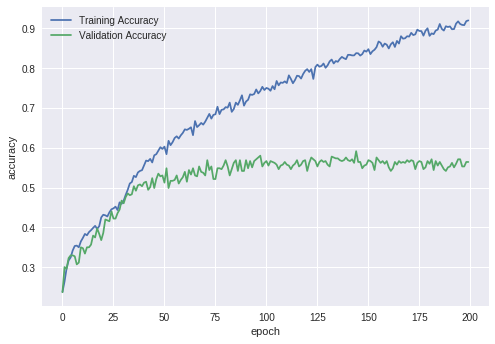

In [19]:
val_acc_filter = history_filter.history['val_acc']

print('Max Validation Accuracy:', max(val_acc_filter))

acc_filter = history_filter.history['acc']
print('Max Training Accuracy:', max(acc_filter))

plt.plot(acc_filter, label = 'Training Accuracy')
plt.plot(val_acc_filter, label = 'Validation Accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()

plt.show()

## Filtering and Subsampling

In [28]:
model_filter_subsample = create_model(n_filters=32, n_neurons=256, drops=[0.05, 0.05, 0.05], subsample_scale=2)

history_filter_subsample = model_filter_subsample.fit(X_train_valid, y_train_valid, validation_data=(X_test, y_test), epochs=200, batch_size=512, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 22, 500, 1)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 250, 32)       96        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 250, 32)        22560     
_________________________________________________________________
elu_4 (ELU)                  (None, 1, 250, 32)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 1, 125, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 125, 32)        0         
_________________________________________________________________
permute_4 (Permute)          (None, 125, 32, 1)        0         
__________

Max Validation Accuracy: 0.6523702
Max Training Accuracy: 0.99172574


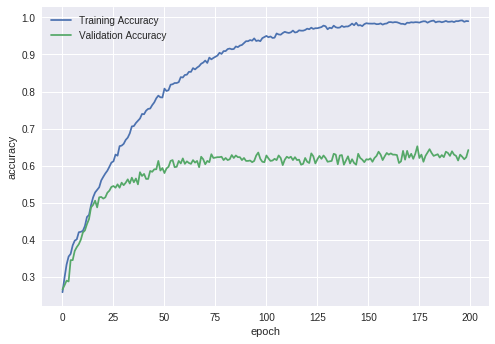

In [29]:
val_acc_filter_subsample = history_filter_subsample.history['val_acc']

print('Max Validation Accuracy:', max(val_acc_filter_subsample))

acc_filter_subsample = history_filter_subsample.history['acc']
print('Max Training Accuracy:', max(acc_filter_subsample))

plt.plot(acc_filter_subsample, label = 'Training Accuracy')
plt.plot(val_acc_filter_subsample, label = 'Validation Accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()

plt.show()

## Performance improvement: model

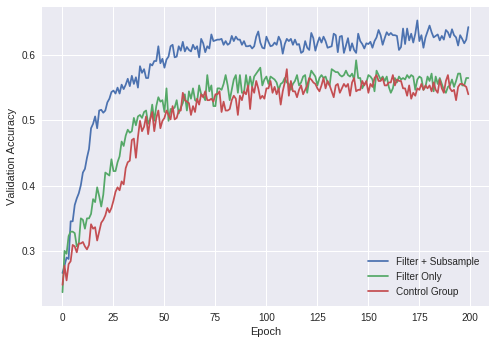

In [30]:
plt.figure()

plt.plot(val_acc_filter_subsample, label = 'Filter + Subsample')
plt.plot(val_acc_filter, label = 'Filter Only')
plt.plot(val_acc_control, label = 'Control Group')


plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')

plt.legend()

plt.show()

In [31]:
(0.66478556 - 0.60722345)/0.60722345

0.09479559789728147

In [32]:
(0.6523702 - 0.5778781) / 0.5778781

0.1289062520278932